# Periphery units, LSOA, regions containing LSOA...

Ways to label them as periphery and draw them on the maps in a different way.

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo

import pandas as pd
import matplotlib.pyplot as plt
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## Load data

__Stroke unit services__ for the calculations and __coordinates__ for the maps

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

gdf_units = stroke_maps.load_data.stroke_unit_coordinates()
# Merge the services information into the coordinates:
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

__LSOA travel time__ for the calculations

In [3]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

__LSOA boundaries__ for the maps

In [4]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

__Region boundaries__ for the maps

In [5]:
gdf_sicbl = stroke_maps.load_data.sicbl_geography()
gdf_lhb = stroke_maps.load_data.lhb_geography()

In [6]:
# Set both to have the same column names:
gdf_sicbl['region'] = gdf_sicbl['SICBL22NM']
gdf_sicbl['region_code'] = gdf_sicbl['SICBL22CD']

gdf_lhb['region'] = gdf_lhb['LHB20NM']
gdf_lhb['region_code'] = gdf_lhb['LHB20CD']

gdf_sicbl['region_type'] = 'SICBL'
gdf_lhb['region_type'] = 'LHB'

In [7]:
# Combine both region types into one geodataframe:
gdf_regions = pd.concat((
    gdf_sicbl[['region', 'region_type', 'region_code', 'geometry']],
    gdf_lhb[['region', 'region_type', 'region_code', 'geometry']]
))

gdf_regions.index = range(len(gdf_regions))

The following colour list is used to colour the catchment areas in the maps.

In [8]:
# Make a list of colour names:
# Expecting to only need a few colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

## Calculate LSOA catchment areas

First we'll create a map of the normal stroke unit catchment areas in the West Midlands when we don't restrict anything.

Limit the travel time matrix to only stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [9]:
mask = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))
postcodes_units = df_units[mask].index.values

# Load the travel time matrix:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()
# Limit it to these units:
df_travel_lsoa = df_travel_lsoa[postcodes_units].copy()

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [10]:
df_catchment = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa)

Limit this results dataframe to only stroke units in the chosen region:

In [11]:
# Which postcodes are in the chosen region?
mask_here = (df_units['isdn'] == 'West Midlands')
postcodes_here = df_units[mask_here].index.values

# Limit the catchment data to only those postcodes:
mask_catchment = df_catchment['unit_postcode'].isin(postcodes_here)
df_catchment = df_catchment[mask_catchment]

This dataframe is allowed to contain LSOA outside the selected region and to not contain LSOA within the selected region.

Combine this data with geometry:

In [12]:
# Merge in the information on nearest acute stroke unit:
gdf_lsoa = pd.merge(
    gdf_lsoa, df_catchment['unit_postcode'],
    left_on='LSOA11NM', right_index=True, how='right'
)
# Combine LSOA with the same acute stroke unit into a single region:
gdf_catchment = stroke_maps.geo.combine_regions(gdf_lsoa, 'unit_postcode')
# Convert the coordinates to British National Grid so that they match other geometry:
gdf_catchment = gdf_catchment.to_crs('EPSG:27700')
# Assign colours:
gdf_catchment['adjacent_colours'] = greedy(
    gdf_catchment, min_distance=1, balance='count').astype(str)
# Assign these colours to the regions:
gdf_catchment['colour_str'] = gdf_catchment['adjacent_colours'].map(colour_map)

## Plot 1: Everything

Crop the extent of the plot to a box just containing the catchment areas, and otherwise plot all of the stroke units and region boundaries in the full data files.

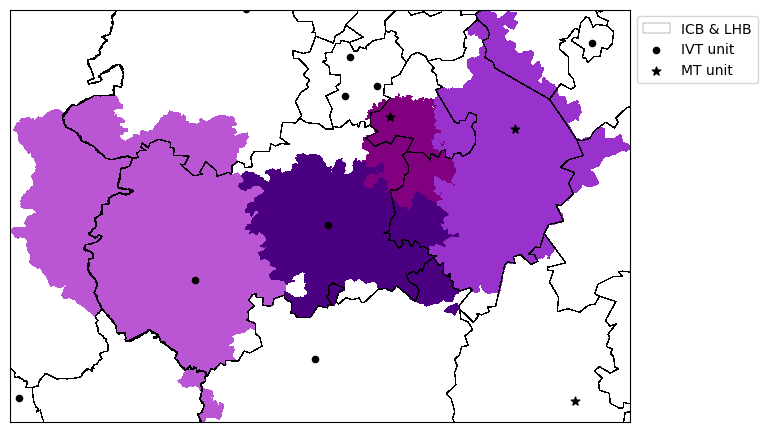

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

# Catchment areas:
gdf_catchment.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    color=gdf_catchment['colour_str'],  # set colours using this column
    linewidth=0.2,
    )

# Setup for ISDN:
kwargs_isdn = dict(
    facecolor='none',
    edgecolor='k',
    linewidth=0.2,
)
# ISDN outlines:
gdf_regions.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    **kwargs_isdn
    )
# Can't put regions like this ^ in the legend, so fake it now.
# Draw an area so small you'll never see it
# and give it the same properties as the wanted region.
points = [p for p in gdf_regions['geometry'].iloc[0].exterior.coords]
x = points[0][0]
y = points[0][1]
ax.fill(
    [x, x+1e-7],
    [y, y+1e-7],
    **kwargs_isdn,
    label='ICB & LHB'
)

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    facecolor='k',
    label='IVT unit',
    s=20,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    facecolor='k',
    label='MT unit',
    s=40,  # size
    )

# Axis limits:
bounds = gdf_catchment.geometry.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Remove the axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add legend:
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()

## Plot 2: Periphery data

Change the formatting so that the main features stand out more.

Assume that the starting point is the selected stroke units, and that we know their LSOA catchment areas.

1. Find the regions that contain the selected stroke units.
2. Find "periphery regions": the regions that contain LSOA caught by the selected stroke units.
3. Find "periphery units": the other stroke units that catch LSOA within the starting region.

### 1. Regions containing selected stroke units:

In [14]:
df_units.loc[postcodes_here][['region', 'region_type', 'isdn']]

,region,region_type,isdn
postcode,,,
B95SS,NHS Birmingham and Solihull ICB - 15E,SICBL,West Midlands
CV22DX,NHS Coventry and Warwickshire ICB - B2M3M,SICBL,West Midlands
CV107DJ,NHS Coventry and Warwickshire ICB - B2M3M,SICBL,West Midlands
HR12ER,NHS Herefordshire and Worcestershire ICB - 18C,SICBL,West Midlands
B152TH,NHS Birmingham and Solihull ICB - 15E,SICBL,West Midlands
CV345BW,NHS Coventry and Warwickshire ICB - B2M3M,SICBL,West Midlands
WR51DD,NHS Herefordshire and Worcestershire ICB - 18C,SICBL,West Midlands


In [15]:
regions_with_selected_units = sorted(list(set(df_units.loc[postcodes_here]['region'].values)))

regions_with_selected_units

['NHS Birmingham and Solihull ICB - 15E',
 'NHS Coventry and Warwickshire ICB - B2M3M',
 'NHS Herefordshire and Worcestershire ICB - 18C']

### 2. Periphery regions

Take the list of LSOA from the catchment results and find the regions that they belong to.

In [16]:
lsoa_selected = df_catchment.index.values

Load in the LSOA-region lookup data:

In [17]:
df_lsoa_regions = stroke_maps.load_data.lsoa_region_lookup()
df_regions = stroke_maps.load_data.region_lookup()

In [18]:
# Link LSOA to further region info:
df_lsoa_regions = pd.merge(
    df_lsoa_regions.reset_index(), df_regions.reset_index().drop(['region', 'region_type'], axis='columns'),
    on='region_code', how='left'
)

In [19]:
# Limit the LSOA in the region list to only the selected ones:
mask = (df_lsoa_regions.reset_index()['lsoa'].isin(lsoa_selected))

df_lsoa_regions_selected = df_lsoa_regions.reset_index()[mask]

In [20]:
df_lsoa_regions_selected.head(3)

,index,lsoa,lsoa_code,region,region_code,region_type,short_code,country,icb,icb_code,isdn
2522,2522,Shropshire 036A,E01028993,"NHS Shropshire, Telford and Wrekin ICB - M2L0M",E38000257,SICBL,SH,England,"NHS Shropshire, Telford and Wrekin Integrated ...",E54000011,North Midlands
2523,2523,Shropshire 037A,E01028994,"NHS Shropshire, Telford and Wrekin ICB - M2L0M",E38000257,SICBL,SH,England,"NHS Shropshire, Telford and Wrekin Integrated ...",E54000011,North Midlands
2524,2524,Shropshire 039A,E01028995,"NHS Shropshire, Telford and Wrekin ICB - M2L0M",E38000257,SICBL,SH,England,"NHS Shropshire, Telford and Wrekin Integrated ...",E54000011,North Midlands


In [21]:
periphery_regions = sorted(list(set(df_lsoa_regions_selected['region'])))

periphery_regions

['Aneurin Bevan University Health Board',
 'NHS Birmingham and Solihull ICB - 15E',
 'NHS Black Country ICB - D2P2L',
 'NHS Buckinghamshire, Oxfordshire and Berkshire West ICB - 10Q',
 'NHS Coventry and Warwickshire ICB - B2M3M',
 'NHS Gloucestershire ICB - 11M',
 'NHS Herefordshire and Worcestershire ICB - 18C',
 'NHS Leicester, Leicestershire and Rutland ICB - 03W',
 'NHS Leicester, Leicestershire and Rutland ICB - 04V',
 'NHS Northamptonshire ICB - 78H',
 'NHS Shropshire, Telford and Wrekin ICB - M2L0M',
 'Powys Teaching Health Board']

Note: if the LSOA have missing region information, the sorted() line will fail because the list will contain mixed strings (for names) and float (for missing values). This can happen when looking up ISDNs because Welsh LSOA are not allocated to any ISDN.

### 3. Periphery units

Redo the catchment calculation with all stroke units and all LSOA in the selected region.

In [22]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

LSOA to keep are those in the selected region:

In [23]:
mask = df_lsoa_regions['isdn'] == 'West Midlands'

lsoa_in_selected_region = df_lsoa_regions[mask]['lsoa'].values

In [24]:
mask = df_travel_lsoa.index.isin(lsoa_in_selected_region)

df_travel_lsoa = df_travel_lsoa[mask]

In [25]:
df_catchment_in_selected_region = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa)

In [26]:
periphery_units = sorted(list(set(df_catchment_in_selected_region['unit_postcode'])))

periphery_units

['B152TH',
 'B714HJ',
 'B95SS',
 'CV107DJ',
 'CV22DX',
 'CV345BW',
 'DY12HQ',
 'GL13NN',
 'HR12ER',
 'WR51DD']

### Place periphery info in starting dataframes

In [27]:
gdf_regions['selected'] = 0
gdf_regions.loc[gdf_regions['region'].isin(regions_with_selected_units), 'selected'] = 1

In [28]:
gdf_regions['periphery'] = 0
gdf_regions.loc[gdf_regions['region'].isin(periphery_regions), 'periphery'] = 1

In [29]:
gdf_units['selected'] = 0
gdf_units.loc[gdf_units.index.isin(postcodes_here), 'selected'] = 1

In [30]:
gdf_units['periphery'] = 0
gdf_units.loc[gdf_units.index.isin(periphery_units), 'periphery'] = 1

## Plot periphery data

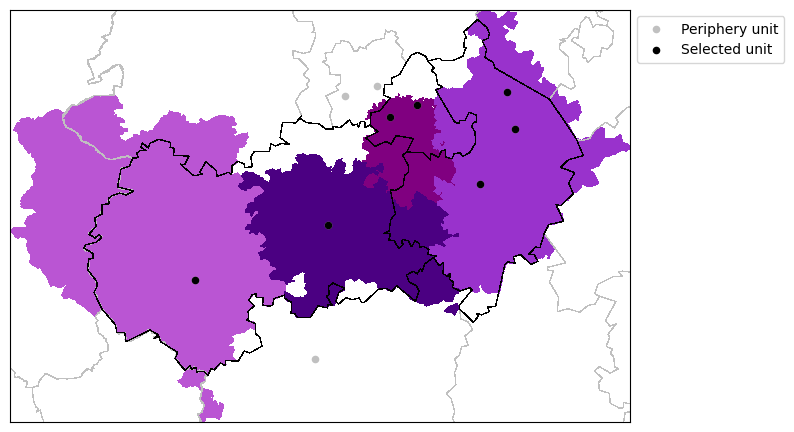

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

# Catchment areas:
gdf_catchment.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    color=gdf_catchment['colour_str'],  # set colours using this column
    linewidth=0.2,
    )

# Region outlines:
gdf_regions.loc[gdf_regions['periphery'] == 1].plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='silver',
    linewidth=0.2,
    )
gdf_regions.loc[gdf_regions['selected'] == 1].plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='k',
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask = ((gdf_units['use_ivt'] == 1) | (gdf_units['use_mt'] == 0))

# IVT units:
mask_selected = mask & (gdf_units['selected'] == 1)
mask_periphery = mask & (gdf_units['periphery'] == 1)
ax.scatter(
    gdf_units.loc[mask_periphery, 'geometry'].x,
    gdf_units.loc[mask_periphery, 'geometry'].y,
    marker='o',
    facecolor='silver',
    label='Periphery unit',
    s=20,  # size
    )
ax.scatter(
    gdf_units.loc[mask_selected, 'geometry'].x,
    gdf_units.loc[mask_selected, 'geometry'].y,
    marker='o',
    facecolor='k',
    label='Selected unit',
    s=20,  # size
    )

# Axis limits:
bounds = gdf_catchment.geometry.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Remove the axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add legend:
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()